# Import Packages

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

In [ ]:
from functools import partial
tqdm = partial(tqdm, position=0, leave=False)

# Load data

In [ ]:
# Transforms are common image transformations. They can be chained together using Compose.
# Here we normalize images img=(img-0.5)/0.5
img_transform = transforms.Compose([
    transforms.Resize((64, 64)),                                
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])
transform_train = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=(-10, 10)),
    transforms.RandomCrop((64, 64), padding=(8, 8)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
])

In [ ]:
# img_file: the pickle file containing the images
# label_file: the .csv file containing the labels
# transform: We use it for normalizing images (see above)
# idx: This is a binary vector that is useful for creating training and validation set.
# It return only samples where idx is True

class MyDataset(Dataset):
    def __init__(self, img_file, label_file, transform=None, idx = None):
        self.data = pickle.load( open( img_file, 'rb' ), encoding='bytes')
        self.targets = np.genfromtxt(label_file, delimiter=',', skip_header=1)[:,1:] - 5 # convert from 5-13 to 0-8
        if idx is not None:
          self.targets = self.targets[idx]
          self.data = self.data[idx]
        self.transform = transform

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index):
        img, target = self.data[index], int(self.targets[index])
        img = Image.fromarray(img.astype('uint8'), mode='L')

        if self.transform is not None:
           img = self.transform(img)

        return img, target

In [ ]:
# Read image data and their label into a Dataset class
dataset = MyDataset('/content/drive/MyDrive/ECSE 551 Group 3/Assignment 3/Train.pkl', '/content/drive/MyDrive/ECSE 551 Group 3/Assignment 3/TrainLabels.csv',transform=transform_train, idx=None)
batch_size = 64 #feel free to change it
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
idx = np.arange(60000)
np.random.shuffle(idx)
train_idx = idx[:50000]
valid_idx = idx[50000:]
# Read image data and their label into a Dataset class
train_dataset = MyDataset('/content/drive/MyDrive/ECSE 551 Group 3/Assignment 3/Train.pkl', '/content/drive/MyDrive/ECSE 551 Group 3/Assignment 3/TrainLabels.csv',transform=transform_train, idx=train_idx)
valid_dataset = MyDataset('/content/drive/MyDrive/ECSE 551 Group 3/Assignment 3/Train.pkl', '/content/drive/MyDrive/ECSE 551 Group 3/Assignment 3/TrainLabels.csv',transform=img_transform, idx=valid_idx)
batch_size = 64 #feel free to change it
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

tensor(0)


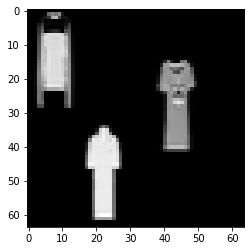

In [ ]:
# Read a batch of data and their labels and display them
# Note that since data are transformed, they are between [-1,1]
imgs, labels = (next(iter(valid_dataloader)))
imgs = np.squeeze(imgs)
plt.imshow(imgs[1].cpu().numpy(),cmap='gray', vmin=-1, vmax=1) #.transpose()
print(labels[1])

In [ ]:
train_classes = {}
for data in train_dataloader:
  [img,label] = data
  # img.type(dtype=dtype)
  # label.type(dtype=dtype)
  for label in label:
    if label.item() not in train_classes:
      train_classes[label.item()] = 1
    else:
      train_classes[label.item()] += 1
valid_classes = {}
for data in valid_dataloader:
  [img,label] = data
  # img.type(dtype=dtype)
  # label.type(dtype=dtype)
  for label in label:
    if label.item() not in valid_classes:
      valid_classes[label.item()] = 1
    else:
      valid_classes[label.item()] += 1

In [ ]:
print(train_classes)
print(valid_classes)

{1: 5538, 8: 5509, 5: 5552, 6: 5539, 2: 5529, 3: 5596, 0: 5555, 4: 5588, 7: 5594}
{8: 1157, 2: 1138, 3: 1071, 6: 1127, 1: 1129, 5: 1115, 4: 1079, 0: 1112, 7: 1072}


# Build Model

### Model 1

In [ ]:
conv_neuron = 25
fc_neuron = 350
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, conv_neuron, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(conv_neuron, conv_neuron*2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(conv_neuron*2, conv_neuron*4, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(conv_neuron*4, conv_neuron*8, kernel_size=3, padding=1)
        self.dropout = nn.Dropout(0.5)
        x = torch.randn(64, 64).view(-1, 1, 64, 64)
        self.to_linear = None
        self.convs(x)
        self.fc1 = nn.Linear(self.to_linear, fc_neuron)
        self.fc2 = nn.Linear(fc_neuron, 9)
    def convs(self, x):
      x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
      x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
      x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))
      x = F.max_pool2d(F.relu(self.conv4(x)), (2, 2))
      if self.to_linear == None:
          self.to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
      return x
    
    def forward(self, x):
      x = self.convs(x)
      x = x.view(-1, self.to_linear)
      x = F.relu(self.fc1(x))
      x = self.dropout(x)
      x = self.fc2(x)
      return F.log_softmax(x, dim=0)

### Model 2

In [ ]:
conv_neuron = 40
fc_neuron = 1024
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, conv_neuron, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(conv_neuron, conv_neuron*2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(conv_neuron*2, conv_neuron*4, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(conv_neuron*4, conv_neuron*8, kernel_size=3, padding=1)
        self.dropout = nn.Dropout(0.5)
        x = torch.randn(64, 64).view(-1, 1, 64, 64)
        self.to_linear = None
        self.convs(x)
        self.fc1 = nn.Linear(self.to_linear, fc_neuron)
        self.fc2 = nn.Linear(fc_neuron, 9)
    def convs(self, x):
      x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
      x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
      x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))
      x = F.max_pool2d(F.relu(self.conv4(x)), (2, 2))
      if self.to_linear == None:
          self.to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
      return x
    
    def forward(self, x):
      x = self.convs(x)
      x = x.view(-1, self.to_linear)
      x = F.relu(self.fc1(x))
      x = self.dropout(x)
      x = self.fc2(x)
      return F.log_softmax(x, dim=0)

### Model 3

In [ ]:
conv_neuron = 32
fc_neuron = 1250
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # First Conv
        self.conv1 = nn.Conv2d(1, conv_neuron, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(conv_neuron, conv_neuron, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(conv_neuron, conv_neuron, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(conv_neuron)
        # Second Conv
        self.conv4 = nn.Conv2d(conv_neuron, conv_neuron*2, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(conv_neuron*2, conv_neuron*2, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(conv_neuron*2, conv_neuron*2, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(conv_neuron*2)
        # Third Conv
        self.conv7 = nn.Conv2d(conv_neuron*2, conv_neuron*4, kernel_size=3, padding=1)
        self.conv8 = nn.Conv2d(conv_neuron*4, conv_neuron*4, kernel_size=3, padding=1)
        self.conv9 = nn.Conv2d(conv_neuron*4, conv_neuron*4, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(conv_neuron*4)
        # Fourth Conv
        self.conv10 = nn.Conv2d(conv_neuron*4, conv_neuron*8, kernel_size=3, padding=1)
        self.conv11 = nn.Conv2d(conv_neuron*8, conv_neuron*8, kernel_size=3, padding=1)
        self.conv12 = nn.Conv2d(conv_neuron*8, conv_neuron*8, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(conv_neuron*8)
        self.dropout = nn.Dropout(0.5)
        x = torch.randn(64, 64).view(-1, 1, 64, 64)
        self.to_linear = None
        self.convs(x)
        self.fc1 = nn.Linear(self.to_linear, fc_neuron)
        self.fc2 = nn.Linear(fc_neuron, fc_neuron//2)
        self.fc3 = nn.Linear(fc_neuron//2, 9)
    def convs(self, x):
      # First block
      x = F.relu(self.conv1(x))
      x = F.relu(self.conv2(x))
      x = F.relu(self.conv3(x))
      x = F.max_pool2d(self.bn1(x), (2, 2))
      # Second block
      x = F.relu(self.conv4(x))
      x = F.relu(self.conv5(x))
      x = F.relu(self.conv6(x))
      x = F.max_pool2d(self.bn2(x), (2, 2))
      # Third block
      x = F.relu(self.conv7(x))
      x = F.relu(self.conv8(x))
      x = F.relu(self.conv9(x))
      x = F.max_pool2d(self.bn3(x), (2, 2))
      # Fourth block
      x = F.relu(self.conv10(x))
      x = F.relu(self.conv11(x))
      x = F.relu(self.conv12(x))
      x = F.max_pool2d(self.bn4(x), (2, 2))
      if self.to_linear == None:
          self.to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
      return x
    
    def forward(self, x):
      x = self.convs(x)
      x = x.view(-1, self.to_linear)
      x = F.relu(self.fc1(x))
      x = self.dropout(x)
      x = F.relu(self.fc2(x))
      x = self.fc3(x)
      return F.log_softmax(x, dim=0)

### Model 4

In [ ]:
conv_neuron = 32
fc_neuron = 1250
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # First Conv
        self.conv1 = nn.Conv2d(1, conv_neuron, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(conv_neuron, conv_neuron, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(conv_neuron)
        # Second Conv
        self.conv3 = nn.Conv2d(conv_neuron, conv_neuron*2, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(conv_neuron*2, conv_neuron*2, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(conv_neuron*2)
        # Third Conv
        self.conv5 = nn.Conv2d(conv_neuron*2, conv_neuron*4, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(conv_neuron*4, conv_neuron*4, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(conv_neuron*4)
        # Fourth Conv
        self.conv7 = nn.Conv2d(conv_neuron*4, conv_neuron*8, kernel_size=3, padding=1)
        self.conv8 = nn.Conv2d(conv_neuron*8, conv_neuron*8, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(conv_neuron*8)
        self.dropout = nn.Dropout(0.5)
        x = torch.randn(64, 64).view(-1, 1, 64, 64)
        self.to_linear = None
        self.convs(x)
        self.fc1 = nn.Linear(self.to_linear, fc_neuron)
        self.fc2 = nn.Linear(fc_neuron, fc_neuron//2)
        self.fc3 = nn.Linear(fc_neuron//2, 9)
        
    def convs(self, x):
      x = F.max_pool2d(self.bn1(F.relu(self.conv2(F.relu(self.conv1(x))))), (2, 2))
      x = F.max_pool2d(self.bn2(F.relu(self.conv4(F.relu(self.conv3(x))))), (2, 2))
      x = F.max_pool2d(self.bn3(F.relu(self.conv6(F.relu(self.conv5(x))))), (2, 2))
      x = F.max_pool2d(self.bn4(F.relu(self.conv8(F.relu(self.conv7(x))))), (2, 2))
      if self.to_linear == None:
          self.to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
      return x
    
    def forward(self, x):
      x = self.convs(x)
      x = x.view(-1, self.to_linear)
      x = F.relu(self.fc1(x))
      x = self.dropout(x)
      x = F.relu(self.fc2(x))
      x = self.fc3(x)
      return F.log_softmax(x, dim=0)

# Train and Validation

In [ ]:
network = Net()
network.to(torch.device("cuda:0"))
optimizer = optim.Adam(network.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-7, verbose=True)
epochs = []
train_losses = []
train_acc = []
valid_losses = []
valid_acc = []

In [ ]:
def train_and_validation(num_epochs):
  # Early Stopping
  early_stop_count = 0
  tolerance = 1e-3
  early_stop = 50
  temp = 0
  for epoch in range(1, num_epochs+1):
    epochs.append(epoch)
    # Training
    network.train()
    correct = 0
    total_train_loss = 0
    loop = tqdm(enumerate(train_dataloader), total=len(train_dataloader), leave=False)
    for batch_idx, (data, target) in loop:
      # Use GPU
      data = data.cuda()
      target = target.cuda()
      optimizer.zero_grad()
      output = network(data)

      # Calculate accuracy
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
      accuracy = correct / ((batch_idx + 1) * batch_size)

      # Back-propagation
      loss = F.nll_loss(output, target) #negative log likelihood loss
      total_train_loss += loss.item()
      avg_loss = total_train_loss / (batch_idx + 1)
      loss.backward()
      optimizer.step()

      # Update progress bar
      loop.set_description(f"Epoch: [{epoch}/{num_epochs}]")
      loop.set_postfix(train_loss = avg_loss, train_acc=accuracy.item())

    # Save losses and accuracy after each epoch
    train_losses.append(avg_loss)
    train_acc.append(accuracy)   

    # Validation
    network.eval()
    total_valid_loss = 0
    correct = 0
    with torch.no_grad():
      for batch_idx, (data, target) in enumerate(valid_dataloader):
        data = data.cuda()
        target = target.cuda()
        output = network(data)
        valid_loss = F.nll_loss(output, target)
        total_valid_loss += F.nll_loss(output, target, size_average=False).item()
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).sum()
        valid_accuracy = correct / len(valid_dataloader.dataset)
      total_valid_loss /= len(valid_dataloader.dataset)
      # Print result for each epoch
      print('Epoch: [{}/{}]: Validation set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(epoch, num_epochs,
        total_valid_loss, correct, len(valid_dataloader.dataset),
        100.0 * valid_accuracy))
      
    # Save losses and accuracy after each epoch 
    valid_losses.append(total_valid_loss)
    valid_acc.append(valid_accuracy.item())  
    # Learning rate schedular
    scheduler.step(total_valid_loss)
    # If the difference is smaller than the tolerance, or if the loss is increasing, add count
    if epoch > 1:
      if early_stop_count == 0:
        difference = valid_losses[epoch-2] - total_valid_loss
      else:
        difference = temp - total_valid_loss
      if difference <= tolerance:
        if early_stop_count == 0:
          # Store the loss value as a temporary value. The subsequent losses will be compared with this value
          temp = valid_losses[epoch-2]
        early_stop_count += 1
      else:
        early_stop_count = 0
      # If the validation loss does not decrease for more than certain steps, stop the training 
      if early_stop_count == early_stop:
        break
    torch.save(network.state_dict(), '/content/drive/MyDrive/ECSE 551 Group 3/Assignment 3/Kuan_Models/model_1.pth')
    torch.save(optimizer.state_dict(), '/content/drive/MyDrive/ECSE 551 Group 3/Assignment 3/Kuan_Models/optimizer_1.pth')

In [ ]:
train_and_validation(200)

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch: [1/200]: Validation set: Avg. loss: 2.1045, Accuracy: 9733/10000 (97%)



Epoch: [2/200]: Validation set: Avg. loss: 2.1095, Accuracy: 9722/10000 (97%)



Epoch: [3/200]: Validation set: Avg. loss: 2.1135, Accuracy: 9716/10000 (97%)



Epoch: [4/200]: Validation set: Avg. loss: 2.1096, Accuracy: 9720/10000 (97%)



Epoch: [5/200]: Validation set: Avg. loss: 2.1070, Accuracy: 9741/10000 (97%)



Epoch: [6/200]: Validation set: Avg. loss: 2.1062, Accuracy: 9726/10000 (97%)



Epoch: [7/200]: Validation set: Avg. loss: 2.1055, Accuracy: 9737/10000 (97%)

Epoch   138: reducing learning rate of group 0 to 6.2500e-05.


Epoch: [8/200]: Validation set: Avg. loss: 2.1035, Accuracy: 9748/10000 (97%)



Epoch: [9/200]: Validation set: Avg. loss: 2.1080, Accuracy: 9745/10000 (97%)



Epoch: [10/200]: Validation set: Avg. loss: 2.1022, Accuracy: 9755/10000 (98%)



Epoch: [11/200]: Validation set: Avg. loss: 2.1038, Accuracy: 9745/10000 (97%)



Epoch: [12/200]: Validation set: Avg. loss: 2.1022, Accuracy: 9759/10000 (98%)



Epoch: [13/200]: Validation set: Avg. loss: 2.0997, Accuracy: 9757/10000 (98%)



Epoch: [14/200]: Validation set: Avg. loss: 2.0996, Accuracy: 9732/10000 (97%)



Epoch: [15/200]: Validation set: Avg. loss: 2.1039, Accuracy: 9740/10000 (97%)



Epoch: [16/200]: Validation set: Avg. loss: 2.1007, Accuracy: 9753/10000 (98%)



Epoch: [17/200]: Validation set: Avg. loss: 2.1054, Accuracy: 9746/10000 (97%)



Epoch: [18/200]: Validation set: Avg. loss: 2.0994, Accuracy: 9745/10000 (97%)



Epoch: [19/200]: Validation set: Avg. loss: 2.1056, Accuracy: 9751/10000 (98%)



Epoch: [20/200]: Validation set: Avg. loss: 2.1043, Accuracy: 9762/10000 (98%)



Epoch: [21/200]: Validation set: Avg. loss: 2.1065, Accuracy: 9732/10000 (97%)



Epoch: [22/200]: Validation set: Avg. loss: 2.1006, Accuracy: 9741/10000 (97%)



Epoch: [23/200]: Validation set: Avg. loss: 2.1029, Accuracy: 9761/10000 (98%)



Epoch: [24/200]: Validation set: Avg. loss: 2.1058, Accuracy: 9750/10000 (98%)

Epoch   155: reducing learning rate of group 0 to 3.1250e-05.


Epoch: [25/200]: Validation set: Avg. loss: 2.1037, Accuracy: 9758/10000 (98%)



Epoch: [26/200]: Validation set: Avg. loss: 2.1004, Accuracy: 9751/10000 (98%)



Epoch: [27/200]: Validation set: Avg. loss: 2.1020, Accuracy: 9756/10000 (98%)



Epoch: [28/200]: Validation set: Avg. loss: 2.1029, Accuracy: 9740/10000 (97%)



Epoch: [29/200]: Validation set: Avg. loss: 2.0993, Accuracy: 9769/10000 (98%)



Epoch: [30/200]: Validation set: Avg. loss: 2.1034, Accuracy: 9761/10000 (98%)

Epoch   161: reducing learning rate of group 0 to 1.5625e-05.


Epoch: [31/200]: Validation set: Avg. loss: 2.0999, Accuracy: 9769/10000 (98%)



Epoch: [32/200]: Validation set: Avg. loss: 2.0987, Accuracy: 9760/10000 (98%)



Epoch: [33/200]: Validation set: Avg. loss: 2.1010, Accuracy: 9762/10000 (98%)



Epoch: [34/200]: Validation set: Avg. loss: 2.1011, Accuracy: 9749/10000 (97%)



Epoch: [35/200]: Validation set: Avg. loss: 2.1024, Accuracy: 9756/10000 (98%)



Epoch: [36/200]:  11%|█         | 86/782 [00:06<00:52, 13.22it/s, train_acc=0.963, train_loss=2.13]

Buffered data was truncated after reaching the output size limit.

## Plot Training Progress

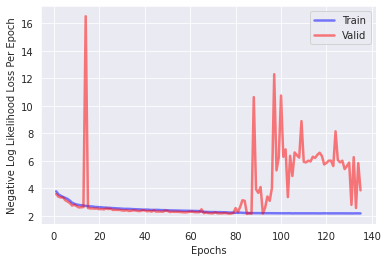

In [ ]:
sns.set_style("darkgrid")
fig = plt.figure()
plt.plot(epochs, train_losses, color='blue', label='Train', alpha=0.5, lw=2.5)
plt.plot(epochs, valid_losses, color='red', label='Valid', alpha=0.5, lw=2.5)
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Negative Log Likelihood Loss Per Epoch')
plt.show()

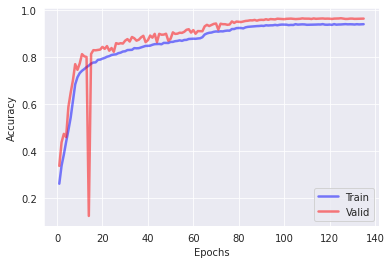

In [ ]:
sns.set_style("darkgrid")
fig = plt.figure()
plt.plot(epochs, train_acc, color='blue', label='Train', alpha=0.5, lw=2.5)
plt.plot(epochs, valid_acc, color='red', label='Valid', alpha=0.5, lw=2.5)
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

# Test Evaluation

In [ ]:
network = Net()
network.to(torch.device("cuda:0"))
optimizer = optim.Adam(network.parameters(), lr=0.001)
schedular = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[60, 90, 100, 110, 115, 120, 125], gamma=0.5)

In [ ]:
def train(num_epochs):
  for epoch in range(1, num_epochs+1):
    epochs.append(epoch)
    # Training
    network.train()
    correct = 0
    total_train_loss = 0
    loop = tqdm(enumerate(dataloader), total=len(dataloader), leave=True)
    for batch_idx, (data, target) in loop:
      # Use GPU
      data = data.cuda()
      target = target.cuda()
      optimizer.zero_grad()
      output = network(data)

      # Calculate accuracy
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
      accuracy = correct / ((batch_idx + 1) * batch_size)

      # Back-propagation
      loss = F.nll_loss(output, target) #negative log likelihood loss
      total_train_loss += loss.item()
      avg_loss = total_train_loss / (batch_idx + 1)
      loss.backward()
      optimizer.step()

      # Update progress bar
      loop.set_description(f"Epoch: [{epoch}/{num_epochs}]")
      loop.set_postfix(train_loss = avg_loss, train_acc=accuracy.item())
    schedular.step()
  torch.save(network.state_dict(), '/content/drive/MyDrive/ECSE 551 Group 3/Assignment 3/Kuan_Models/model_final.pth')
  torch.save(optimizer.state_dict(), '/content/drive/MyDrive/ECSE 551 Group 3/Assignment 3/Kuan_Models/optimizer_final.pth')

In [ ]:
train(70)

Epoch: [25/70]:  53%|█████▎    | 501/938 [01:03<00:48,  9.07it/s, train_acc=0.783, train_loss=2.72]

Buffered data was truncated after reaching the output size limit.

In [ ]:
# Read image data and their label into a Dataset class
test_dataset = MyDataset('/content/drive/MyDrive/Kuan/Test.pkl', '/content/drive/MyDrive/Kuan/TrainLabels.csv',transform=img_transform, idx=np.arange(10000))
batch_size = 64 #feel free to change it
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
network.eval()
total_pred = []
with torch.no_grad():
  for idx, (data, target) in enumerate(test_dataloader):
    data = data.cuda()
    target = target.cuda()
    output = network(data)
    pred = output.data.max(1, keepdim=True)[1] + 5
    if idx == 0:
      total_pred = pred
    else:
      total_pred = torch.cat([total_pred, pred], dim=0)

In [ ]:
# Submission
total_pred = np.array(total_pred.cpu().detach())
submission = pd.DataFrame(total_pred)
submission.to_csv('/content/drive/MyDrive/Kuan/kuan_submission_3_new.csv')